# Install packages and download data
> Need use GPU backend !

In [ ]:
!nvidia-smi

Sun Sep 21 09:34:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!sudo apt update
!sudo apt install libvips libvips-dev openslide-tools


In [ ]:
!pip install expression-copilot[torch]
!pip install git+https://github.com/mahmoodlab/HEST.git

We download the Visium data from 10x website. They are the standard format output by the 10x space-ranger software:
1. histology image
2. `filtered_feature_bc_matrix.h5` (spatial-ranger output)
3. `spatial/` (spatial-ranger output)

In [ ]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/2.0.1/CytAssist_11mm_FFPE_Human_Lung_Cancer/CytAssist_11mm_FFPE_Human_Lung_Cancer_filtered_feature_bc_matrix.h5
!wget https://cf.10xgenomics.com/samples/spatial-exp/2.0.1/CytAssist_11mm_FFPE_Human_Lung_Cancer/CytAssist_11mm_FFPE_Human_Lung_Cancer_tissue_image.tif
!wget https://cf.10xgenomics.com/samples/spatial-exp/2.0.1/CytAssist_11mm_FFPE_Human_Lung_Cancer/CytAssist_11mm_FFPE_Human_Lung_Cancer_spatial.tar.gz
!tar -zxvf CytAssist_11mm_FFPE_Human_Lung_Cancer_spatial.tar.gz

# Extract image embedding via HEST and UNI
> (Estimated time: ~10 min)

In [ ]:
import os
os.environ["SCIPY_ARRAY_API"] = "1" # specific for colab cuml

In [ ]:
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import hest
import numpy as np
import scanpy as sc
import torch
from hestcore.datasets import H5HESTDataset
from hest.bench.cpath_model_zoo.inference_models import inf_encoder_factory
from torch.utils.data import DataLoader
from hest.bench.benchmark import embed_tiles
from hest import VisiumReader

from expression_copilot import ExpressionCopilotModel


We use `UNI` model to extract the tile embeddings, so you should apply the access to `UNI` model in hugginface ([link](https://huggingface.co/MahmoodLab/UNI)) at first and login. More details of the `UNI` model is avaliable at its manuscript on *Nature Medicine* (https://www.nature.com/articles/s41591-024-02857-3)

In [ ]:
from huggingface_hub import login
login(new_session=False)

Input files:
1. histology image
2. `filtered_feature_bc_matrix.h5` (spatial-ranger output)
3. `spatial/` (spatial-ranger output)




In [ ]:
fullres_img_path = './CytAssist_11mm_FFPE_Human_Lung_Cancer_tissue_image.tif'
bc_matrix_path = './CytAssist_11mm_FFPE_Human_Lung_Cancer_filtered_feature_bc_matrix.h5'
spatial_coord_path = './spatial'

st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
    spatial_coord_path=spatial_coord_path # path to a space ranger spatial/ folder containing either a tissue_positions.csv or tissue_position_list.csv
)

alignment file is  None


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6195 × 18085
    var: 'gene_ids', 'feature_types', 'genome'
trim the barcodes


/usr/local/lib/python3.12/dist-packages/hestcore/wsi.py:27: UserWarning: CuImage is not available. Ensure you have a GPU and cucim installed to use GPU acceleration.
  warnings.warn("CuImage is not available. Ensure you have a GPU and cucim installed to use GPU acceleration.")


In [ ]:
st

        'pixel_size' is 0.27371123488454296
        'wsi' is <width=38510, height=32875, backend=NumpyWSI>
        'shapes': []

In [ ]:
st.segment_tissue()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

deeplabv3_seg_v4.ckpt:   0%|          | 0.00/486M [00:00<?, ?B/s]

100%|██████████| 48/48 [00:12<00:00,  3.97it/s]


,tissue_id,geometry
0,0,"POLYGON ((11063 739.9, 11062.99 739.9, 11062.9..."


/usr/local/lib/python3.12/dist-packages/hest/HESTData.py:335: UserWarning: Filtered 5 spots outside the WSI
  warnings.warn(f"Filtered {len_tmp - len(coords_topleft)} spots outside the WSI")
100%|██████████| 6167/6167 [00:18<00:00, 333.09it/s]


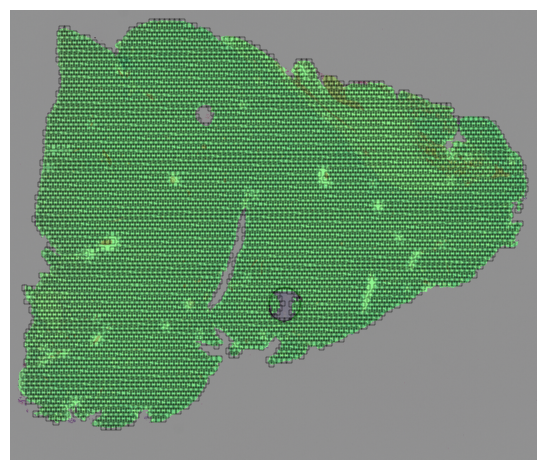

In [ ]:
st.dump_patches(patch_save_dir='./')

In [ ]:
def get_tile_emb(
    tile_h5_path: Path,
    save_path: Path,
    tile_encoder_name: str = "uni_v1",
    batch_size: int = 8,
    force: bool = False,
) -> None:
    save_path = Path(save_path)
    if save_path.exists() and not force:
        print(f"File {save_path} already exists")
        return
    save_path.parent.mkdir(exist_ok=True, parents=True)

    encoder = inf_encoder_factory(tile_encoder_name)()
    precision = encoder.precision
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    _ = encoder.eval()
    encoder.to(device)

    tile_dataset = H5HESTDataset(
        tile_h5_path, chunk_size=batch_size, img_transform=encoder.eval_transforms
    )
    tile_dataloader = DataLoader(tile_dataset, batch_size=1, shuffle=False, num_workers=8)
    _ = embed_tiles(tile_dataloader, encoder, save_path, device, precision)

In [ ]:
get_tile_emb('./patches.h5', save_path='./patches.emb.h5')


  0%|          | 0/6167 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/hest/bench/benchmark.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=precision):
100%|██████████| 6167/6167 [02:33<00:00, 40.17it/s]


# Calculate EPS and SPS
> Please see [Basic Tutorial](https://colab.research.google.com/drive/1Pa4tdloKcZAa7nqrmURMjS9cdwCzOL9R?usp=sharing) for more details.

In [ ]:
# load the UNI embeddings of spot images
with h5py.File('patches.emb.h5', "r") as f:
    print("Keys: %s" % f.keys())
    emb = f['embeddings'][()]
    barcodes = f['barcodes'][()].astype(str)
    coords = f['coords'][()]

Keys: <KeysViewHDF5 ['barcodes', 'coords', 'embeddings']>


In [ ]:
adata = st.adata[st.adata.obs_names.isin(np.squeeze(barcodes))].copy()

In [ ]:
del st # save memory

In [ ]:
adata.obsm['X_uni'] = emb

In [ ]:
# create model
model = ExpressionCopilotModel(adata, 'X_uni')

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:151: UserWarning: zero-centering a sparse array/matrix densifies it.
  return func(*args, **kwargs)


In [ ]:
eps = model.calc_metrics_per_gene()

13:48:50 | INFO | Gene metrics: 
            EPS
CHGA   0.047996
MYH11  0.050165
MYL9   0.056183


In [ ]:
sps = eps.mean().values
print(f"Spatial predictability score (SPS): {sps[0]:.4f}")

Spatial predictability score (SPS): 0.8738


In [ ]:
baseline_metrics_per_gene, _ = model.calc_baseline_metrics(method = 'mlp')

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/tmp/ipython-input-1701398585.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  baseline_metrics_per_gene, _ = model.calc_baseline_metrics(method = 'mlp')
/usr/local/lib/python3.12/dist-packages/expression_copilot/model.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  self.baseline_gene_metrics = pred_model.cal_metrics(pred_model.y_test, y_pred, gene_name)


13:51:27 | INFO | Baseline: mlp gene metrics: 
pearson_corr     0.221790
spearman_corr    0.149221
pearson_pval     0.089087
spearman_pval    0.094936
rmse             0.957236
dtype: float64


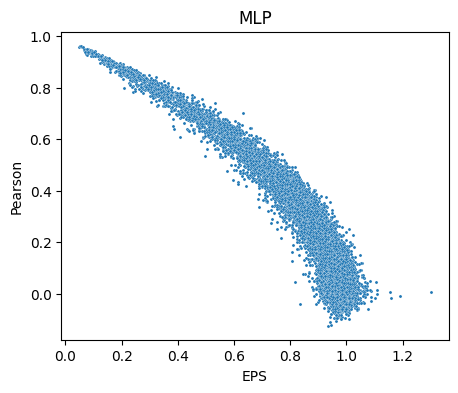

In [ ]:
plt.figure(figsize=(5,4))
ax = sns.scatterplot(x=eps['EPS'], y=baseline_metrics_per_gene['pearson_corr'], s=5)
ax.set_ylabel('Pearson')
ax.set_xlabel('EPS')
ax.set_title('MLP')
plt.show()